In [1]:
! . .venv/bin/activate
! sstat -j $SLURM_JOB_ID 

JobID         MaxVMSize  MaxVMSizeNode  MaxVMSizeTask  AveVMSize     MaxRSS MaxRSSNode MaxRSSTask     AveRSS MaxPages MaxPagesNode   MaxPagesTask   AvePages     MinCPU MinCPUNode MinCPUTask     AveCPU   NTasks AveCPUFreq ReqCPUFreqMin ReqCPUFreqMax ReqCPUFreqGov ConsumedEnergy  MaxDiskRead MaxDiskReadNode MaxDiskReadTask  AveDiskRead MaxDiskWrite MaxDiskWriteNode MaxDiskWriteTask AveDiskWrite TRESUsageInAve TRESUsageInMax TRESUsageInMaxNode TRESUsageInMaxTask TRESUsageInMin TRESUsageInMinNode TRESUsageInMinTask TRESUsageInTot TRESUsageOutAve TRESUsageOutMax TRESUsageOutMaxNode TRESUsageOutMaxTask TRESUsageOutMin TRESUsageOutMinNode TRESUsageOutMinTask TRESUsageOutTot 
------------ ---------- -------------- -------------- ---------- ---------- ---------- ---------- ---------- -------- ------------ -------------- ---------- ---------- ---------- ---------- ---------- -------- ---------- ------------- ------------- ------------- -------------- ------------ --------------- --------------- 

# Load the data 
### Get data from running all of data_analysis/create_dataset

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, mean_absolute_error, mean_squared_error, r2_score, confusion_matrix
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns


In [12]:
# Load the data from model_data 
version = 'v1'
train = pd.read_csv(f'model_data/{version}/train.csv')
val = pd.read_csv(f'model_data/{version}/val.csv')
test = pd.read_csv(f'model_data/{version}/test.csv')

# Split the data into X and y
x_train = train.drop(columns=['causedPressure'])
y_train = train['causedPressure']

x_val = val.drop(columns=['causedPressure'])
y_val = val['causedPressure']

x_test = test.drop(columns=['causedPressure'])
y_test = test['causedPressure']

#print train cols
print(x_train.columns)

Index(['formation_EMPTY', 'formation_I_FORM', 'formation_JUMBO',
       'formation_PISTOL', 'formation_SHOTGUN', 'formation_SINGLEBACK',
       'formation_WILDCAT', 'formation_2-Man', 'formation_Bracket',
       'formation_Cover 6-Left', 'formation_Cover-0', 'formation_Cover-1',
       'formation_Cover-1 Double', 'formation_Cover-2', 'formation_Cover-3',
       'formation_Cover-3 Cloud Left', 'formation_Cover-3 Cloud Right',
       'formation_Cover-3 Double Cloud', 'formation_Cover-3 Seam',
       'formation_Cover-6 Right', 'formation_Goal Line',
       'formation_Miscellaneous', 'formation_Prevent', 'formation_Quarters',
       'formation_Red Zone', 'C', 'CB', 'DE', 'DT', 'FS', 'G', 'ILB', 'NT',
       'QB', 'RB', 'SS', 'T', 'TE', 'WR', 'FB', 'OLB', 'MLB', 'DB', 'LB',
       'quarter', 'down', 'yardsToGo', 'inMotionAtBallSnap'],
      dtype='object')


# XGBoost model

In [4]:
model = XGBClassifier(
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss',  
    early_stopping_rounds=10

)

model.fit(
    x_train,
    y_train,
    eval_set=[(x_val, y_val)],
    verbose=True
)

y_pred = model.predict(x_test)

/blue/hoover-sai/NFL_Big_Data_Bowl_2025/team1/aaron_dir/big-data-bowl/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [09:44:02] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-logloss:0.68351
[1]	validation_0-logloss:0.67790
[2]	validation_0-logloss:0.67417
[3]	validation_0-logloss:0.67266
[4]	validation_0-logloss:0.67249
[5]	validation_0-logloss:0.67231
[6]	validation_0-logloss:0.67384
[7]	validation_0-logloss:0.67356
[8]	validation_0-logloss:0.67493
[9]	validation_0-logloss:0.67490
[10]	validation_0-logloss:0.67521
[11]	validation_0-logloss:0.67732
[12]	validation_0-logloss:0.67859
[13]	validation_0-logloss:0.67942
[14]	validation_0-logloss:0.67938


# Train Accuracy
### Dummy Model (guesses no pressure everytime) accuracy is 50%
### Goal: Beat Dummy Model

In [5]:
print(f"train accuracy = {accuracy_score(y_train, model.predict(x_train))}")

train accuracy = 0.6588267847260653


# Test Metrics
### Dummy Model (guesses no pressure everytime) accuracy is 70%
### Good weigthed average f1 score is > .70

In [7]:
print("Classification Report on Test Set:")
print(classification_report(y_test, y_pred))

Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.75      0.66      0.70       890
           1       0.39      0.49      0.43       387

    accuracy                           0.61      1277
   macro avg       0.57      0.58      0.57      1277
weighted avg       0.64      0.61      0.62      1277



Perfect confusion matrix for comparison:
[[890   0]
 [  0 387]]


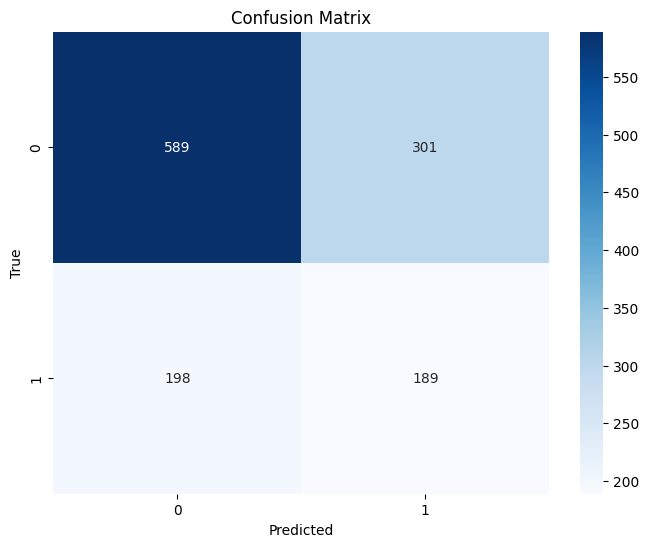

In [8]:
# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

print("Perfect confusion matrix for comparison:")
print(confusion_matrix(y_test, y_test))

# Optional: Visualize the confusion matrix with a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Hyperparamater Tuning

Fitting 3 folds for each of 20 candidates, totalling 60 fits


/blue/hoover-sai/NFL_Big_Data_Bowl_2025/team1/aaron_dir/big-data-bowl/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [09:50:15] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/blue/hoover-sai/NFL_Big_Data_Bowl_2025/team1/aaron_dir/big-data-bowl/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [09:50:15] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/blue/hoover-sai/NFL_Big_Data_Bowl_2025/team1/aaron_dir/big-data-bowl/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [09:50:15] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/blue/hoover-sai/NFL_Big_Data_Bowl_2025/team1/aaron_dir/big-data-bowl/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [09:50:15] WARNING: /workspace

Best parameters found:  {'subsample': 0.6, 'reg_lambda': 10, 'reg_alpha': 0.01, 'n_estimators': 400, 'min_child_weight': 3, 'max_depth': 3, 'learning_rate': 0.001, 'gamma': 1, 'colsample_bytree': 0.7}
Best CV accuracy:  0.5498097627548558
Validation Accuracy with tuned model: 0.6336
Test Accuracy with tuned model: 0.6453
Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.75      0.73      0.74       890
           1       0.42      0.45      0.43       387

    accuracy                           0.65      1277
   macro avg       0.59      0.59      0.59      1277
weighted avg       0.65      0.65      0.65      1277

Confusion Matrix:
[[650 240]
 [213 174]]


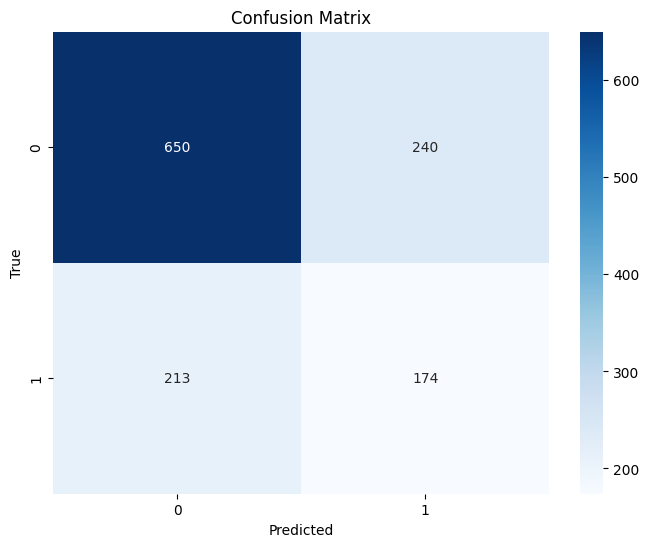

In [14]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
import numpy as np

# 1. Define a parameter grid for XGBoost hyperparameters
param_dist = {
    "n_estimators": [50, 100, 200, 300, 400, 500],  # More options for number of trees
    "max_depth": [3, 4, 5, 6, 8, 10, 12],           # Wider range of tree depths
    "learning_rate": [0.5, 0.1, 0.01, 0.001, 0.0001],  # Extended learning rates
    "subsample": [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],    # Finer granularity for subsample
    "colsample_bytree": [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],  # More options for feature sampling
    "min_child_weight": [1, 2, 3, 4, 5, 10],        # Wider range for regularization
    "gamma": [0, 0.1, 0.3, 0.5, 1, 2],              # Add higher gamma values
    "reg_alpha": [0, 0.01, 0.1, 1, 10, 100],        # Wider range for L1 regularization
    "reg_lambda": [0, 0.01, 0.1, 1, 10, 100]        # Wider range for L2 regularization
}

# 2. Initialize an XGBoost classifier
xgb_clf = XGBClassifier(
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

# 3. Instantiate the RandomizedSearchCV
#    n_iter: number of random parameter settings to try
#    cv: number of folds in cross-validation
#    scoring: metric used for selection
random_search = RandomizedSearchCV(
    estimator=xgb_clf,
    param_distributions=param_dist,
    n_iter=20,                  # Adjust to your preference
    scoring='accuracy',         # Could be 'f1', 'roc_auc', etc. depending on the problem
    cv=3,                       # K-fold cross-validation
    verbose=1,
    random_state=42,
    n_jobs=-1                   # Use all available cores
)

# 4. Fit the RandomizedSearchCV on your training set
random_search.fit(x_train, y_train)

# 5. Check best parameters and score
print("Best parameters found: ", random_search.best_params_)
print("Best CV accuracy: ", random_search.best_score_)

# 6. Use the best_estimator_ to predict on validation/test set
best_model = random_search.best_estimator_

# If you have a separate validation set
y_val_pred = best_model.predict(x_val)
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy with tuned model: {val_accuracy:.4f}")

# 7. Evaluate on test set
y_test_pred = best_model.predict(x_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy with tuned model: {test_accuracy:.4f}")

print("Classification Report on Test Set:")
print(classification_report(y_test, y_test_pred))

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_test_pred)

# Print the raw confusion matrix
print("Confusion Matrix:")
print(cm)

# Optional: Visualize the confusion matrix with a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=best_model.classes_, yticklabels=best_model.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [15]:
# Get feature importance
importance = best_model.get_booster().get_score(importance_type='gain')

# Sort features by importance
sorted_importance = sorted(importance.items(), key=lambda x: x[1], reverse=True)

# Print sorted feature importance
print("Feature Importance (sorted by gain):")
for feature, score in sorted_importance:
    print(f"{feature}: {score}")


# shap values!!

Feature Importance (sorted by gain):
down: 20.958715438842773
CB: 7.355044364929199
formation_Cover-2: 5.755290508270264
TE: 5.492403030395508
WR: 5.240168571472168
formation_Cover-0: 5.093026161193848
formation_SINGLEBACK: 4.937557697296143
yardsToGo: 4.571583271026611
formation_Cover-1: 4.434298515319824
DE: 4.404196739196777
FS: 4.398242950439453
DT: 4.396081447601318
quarter: 4.0159382820129395
C: 4.002424240112305
formation_Red Zone: 3.82598876953125
T: 3.6026597023010254
inMotionAtBallSnap: 3.5076916217803955
formation_Cover 6-Left: 3.501145839691162
NT: 3.469071865081787
G: 3.428128719329834
formation_Cover-6 Right: 3.3541905879974365
formation_Cover-3 Seam: 3.1557023525238037
MLB: 3.025355100631714
OLB: 2.9785146713256836
LB: 2.893104076385498
FB: 2.809593439102173
formation_SHOTGUN: 2.7753427028656006
formation_I_FORM: 2.6909384727478027
SS: 2.603349208831787
formation_Cover-3: 2.6010499000549316
ILB: 2.5325074195861816
formation_2-Man: 2.4928815364837646
formation_EMPTY: 2.27